In [1]:
using Markdown#hide

# Monte Carlo (Concrete) Dropout: Bayesian Neural Network (BNN) for a regression task

From [https://github.com/aurelio-amerio/ConcreteDropout/blob/main/examples/Tensorflow/regression_MCDropout.ipynb](https://github.com/aurelio-amerio/ConcreteDropout/blob/main/examples/Tensorflow/regression_MCDropout.ipynb).
For more information on this BNN implementation, see https://arxiv.org/pdf/1703.04977.pdf

In [2]:
using Lux
using Lux.Training: TrainState
using LuxCUDA
dev = gpu_device()

using Optimisers
using Zygote # AD
using Random
using MLUtils: DataLoader
using StatsBase
using ConcreteDropoutLayer

Random.seed!(MersenneTwister(1))

MersenneTwister(0x8b4cc49499d7e333b475e95edf5e8045)

## Data

In [3]:
function gen_data(N; in=1, out=1)
    X = randn(Float32, Q, N)
    σ = 1
    w = 2
    b = 8
    Y = w * ones(out, in) * X .+ b + σ * randn(Float32, out, N)
    return X, Y
end

gen_data (generic function with 1 method)

## Neural network functions

In [4]:
function build_model_dropout(in, out)
    Chain(
        Dense(in => 100, relu),
        Dense(100 => 100, relu),
        ConcreteDropout(),
        Dense(100 => 100, relu),
        ConcreteDropout(),
        Parallel(nothing,
            Chain(Dense(100 => out, relu), ConcreteDropout()),
            Chain(Dense(100 => out, relu), ConcreteDropout())
        )
    )
end

function build_model_dropout(in, out, p)
    Chain(
        Dense(in => 100, relu),
        Dense(100 => 100, relu),
        Dropout(p),
        Dense(100 => 100, relu),
        Dropout(p),
        Parallel(nothing,
            Chain(Dense(100 => out, relu), Dropout(p)),
            Chain(Dense(100 => out, relu), Dropout(p))
        )
    )
end

build_model_dropout (generic function with 2 methods)

## Loss functions

In [5]:
function heteroscedastic_loss(y_pred, y_true)
    μ, log_var = y_pred
    precision = exp.(-log_var)
    return sum(precision .* (y_true - μ) .^ 2 + log_var)
end

function compute_loss_heteroscedastic(model, ps, st, (x, y))
    ŷ, st = model(x, ps, st)
    return heteroscedastic_loss(ŷ, y), st, ()
end

compute_loss_heteroscedastic (generic function with 1 method)

Version with the added regularization suggested in the original paper. `(names_CD, names_W, input_features), λp, λW` are provided and constant during the training.

In [6]:
function compute_loss_heteroscedastic_w_reg(model, ps, st, (x, y), (keys_CD, keys_W, input_features, λp, λW))
    ŷ, st = model(x, ps, st)
    drop_rates = get_CD_rates(ps, keys_CD)
    W = get_CD_weigths(ps, keys_W)
    return heteroscedastic_loss(ŷ, y) + computeCD_reg(drop_rates, W, input_features, λp, λW), st, ()
end

compute_loss_heteroscedastic_w_reg (generic function with 1 method)

## Training functions

In [7]:
"""
	train_NN([rng], model, epochs, dataset, dataset_val, compute_loss; opt=Adam(0.001f0), dev = cpu_device(), adtype)
	train_NN(train_state, epochs, dataset, dataset_val, compute_loss; opt=Adam(0.001f0), dev = cpu_device(), adtype)
Train the `model` or `train_state` and comute at each epoch the training and testing loss.
"""
function train_NN(train_state::TrainState, epochs, dataset, dataset_val, compute_loss; dev = cpu_device(), adtype)
    ps = train_state.parameters
    st = train_state.states
    model = train_state.model

    # Validation Loss
    losses_train = Float32[]
    x_val, y_val = dataset_val |> dev
    losses_val = Float32[first(compute_loss(model, ps, st, (x_val, y_val)))]
    loss = rand(Float32) # just to define loss in outer loop scope # probably better ways to do that
    best_test_state = train_state

    # Training loop
    for epoch in 1:epochs
        issave = false
        for xy in dataset
            xy = xy |> dev
            loss, train_state = train_step(train_state, xy, compute_loss; adtype = adtype)
        end
        ps = train_state.parameters
        st = train_state.states
        loss_val = first(compute_loss(model, ps, st, (x_val, y_val)))
        if loss_val < minimum(losses_val)
            best_test_state = train_state
            issave = true
        end
        append!(losses_train, loss)
        append!(losses_val, loss_val)
        @info "Epoch $epoch train_loss = $(round(loss, digits = 4)) validation_loss = $(round(loss_val, digits = 4)) $(issave ? "Best model so far" : " ")"
    end
    return best_test_state, losses_train, losses_val
end

function train_NN(rng::AbstractRNG, model, epochs, dataset, dataset_val, compute_loss; opt=Adam(0.001f0), dev = cpu_device(), adtype)
    ps, st = Lux.setup(rng, model) |> dev

    train_state = TrainState(model, ps, st, opt)
    return train_NN(train_state, epochs, dataset, dataset_val, compute_loss; dev = dev, adtype = adtype)
end

train_NN(model, epochs, dataset, dataset_val, compute_loss; opt=Adam(0.001f0), dev = cpu_device(), adtype) = train_NN(Random.Xoshiro(0), model, epochs, dataset, dataset_val, compute_loss; opt=opt, dev = dev, adtype = adtype)

function train_step(train_state, xy, compute_loss; adtype)
    # Calculate the gradient of the objective
    # with respect to the parameters within the model:
    x, y = xy
    gs, loss, stats, train_state = Training.single_train_step!(adtype, compute_loss, (x, y), train_state)
    return loss, train_state
end

train_step (generic function with 1 method)

# Data & Settings

In [8]:
Q = 1
D = 1
n_train = 1000
n_test = 500

x_train, y_train = gen_data(n_train, in=Q, out=D)

x_test, y_test = gen_data(n_test, in=Q, out=D)

batch_size = 128
epochs = 100
data_train = DataLoader((x_train, y_train), batchsize=batch_size) |> dev
data_test = (x_test, y_test) |> dev

(Float32[0.7223454 -1.3774185 … 1.3872432 -0.059217952], Float32[8.6500635 5.6452885 … 10.990209 8.417305])

# Training

## Dropout Model

In [9]:
fix_dropout = 0.1
model_D = build_model_dropout(Q, D, fix_dropout)

Chain(
    layer_1 = Dense(1 => 100, relu),    # 200 parameters
    layer_2 = Dense(100 => 100, relu),  # 10_100 parameters
    layer_3 = Dropout(0.1),
    layer_4 = Dense(100 => 100, relu),  # 10_100 parameters
    layer_5 = Dropout(0.1),
    layer_6 = Parallel(
        layer_1 = Chain(
            layer_1 = Dense(100 => 1, relu),  # 101 parameters
            layer_2 = Dropout(0.1),
        ),
        layer_2 = Chain(
            layer_1 = Dense(100 => 1, relu),  # 101 parameters
            layer_2 = Dropout(0.1),
        ),
    ),
)         # Total: 20_602 parameters,
          #        plus 8 states.

In [10]:
@time "Dropout model" model_state_out_D, loss_train_D, loss_val_D = train_NN(model_D, epochs, data_train, data_test, compute_loss_heteroscedastic; dev = gpu_device(), adtype = AutoZygote())

┌ Warning: `training` is set to `Val{true}()` but is not being used within an autodiff call (gradient, jacobian, etc...). This will be slow. If you are using a `Lux.jl` model, set it to inference (test) mode using `LuxCore.testmode`. Reliance on this behavior is discouraged, and is not guaranteed by Semantic Versioning, and might be removed without a deprecation cycle. It is recommended to fix this issue in your code.
└ @ LuxLib.Utils C:\Users\metivier\.julia\packages\LuxLib\ru5RQ\src\utils.jl:314
[ Info: Epoch 1 train_loss = 2087.0425 validation_loss = 13435.351 Best model so far
[ Info: Epoch 2 train_loss = 1189.7493 validation_loss = 7637.4214 Best model so far
[ Info: Epoch 3 train_loss = 690.4441 validation_loss = 3996.872 Best model so far
[ Info: Epoch 4 train_loss = 741.2814 validation_loss = 3778.517 Best model so far
[ Info: Epoch 5 train_loss = 626.4408 validation_loss = 3309.3516 Best model so far
[ Info: Epoch 6 train_loss = 774.6878 validation_loss = 2802.0864 Best model 

(TrainState{Nothing, Nothing, Chain{@NamedTuple{layer_1::Dense{typeof(relu), Int64, Int64, Nothing, Nothing, Static.True}, layer_2::Dense{typeof(relu), Int64, Int64, Nothing, Nothing, Static.True}, layer_3::Dropout{Float64, Colon}, layer_4::Dense{typeof(relu), Int64, Int64, Nothing, Nothing, Static.True}, layer_5::Dropout{Float64, Colon}, layer_6::Parallel{Nothing, @NamedTuple{layer_1::Chain{@NamedTuple{layer_1::Dense{typeof(relu), Int64, Int64, Nothing, Nothing, Static.True}, layer_2::Dropout{Float64, Colon}}, Nothing}, layer_2::Chain{@NamedTuple{layer_1::Dense{typeof(relu), Int64, Int64, Nothing, Nothing, Static.True}, layer_2::Dropout{Float64, Colon}}, Nothing}}, Nothing}}, Nothing}, @NamedTuple{layer_1::@NamedTuple{weight::CuArray{Float32, 2, CUDA.DeviceMemory}, bias::CuArray{Float32, 1, CUDA.DeviceMemory}}, layer_2::@NamedTuple{weight::CuArray{Float32, 2, CUDA.DeviceMemory}, bias::CuArray{Float32, 1, CUDA.DeviceMemory}}, layer_3::@NamedTuple{}, layer_4::@NamedTuple{weight::CuArray

## Concrete Dropout Model

### Without regularization

In [11]:
model_CD = build_model_dropout(Q, D)

Chain(
    layer_1 = Dense(1 => 100, relu),    # 200 parameters
    layer_2 = Dense(100 => 100, relu),  # 10_100 parameters
    layer_3 = ConcreteDropout(),        # 1 parameters, plus 2
    layer_4 = Dense(100 => 100, relu),  # 10_100 parameters
    layer_5 = ConcreteDropout(),        # 1 parameters, plus 2
    layer_6 = Parallel(
        layer_1 = Chain(
            layer_1 = Dense(100 => 1, relu),  # 101 parameters
            layer_2 = ConcreteDropout(),  # 1 parameters, plus 2
        ),
        layer_2 = Chain(
            layer_1 = Dense(100 => 1, relu),  # 101 parameters
            layer_2 = ConcreteDropout(),  # 1 parameters, plus 2
        ),
    ),
)         # Total: 20_606 parameters,
          #        plus 8 states.

In [12]:
@time "Concrete Dropout model" model_state_out_CD, loss_train_CD, loss_val_CD = train_NN(model_CD, epochs, data_train, data_test, compute_loss_heteroscedastic; dev = gpu_device(), adtype = AutoZygote())

[ Info: Epoch 1 train_loss = 1423.3564 validation_loss = 6284.044 Best model so far
[ Info: Epoch 2 train_loss = 1104.726 validation_loss = 4580.6733 Best model so far
[ Info: Epoch 3 train_loss = 594.9466 validation_loss = 4530.5425 Best model so far
[ Info: Epoch 4 train_loss = 550.6051 validation_loss = 3320.868 Best model so far
[ Info: Epoch 5 train_loss = 567.7684 validation_loss = 3453.0952  
[ Info: Epoch 6 train_loss = 501.4726 validation_loss = 2645.3477 Best model so far
[ Info: Epoch 7 train_loss = 438.1162 validation_loss = 2449.958 Best model so far
[ Info: Epoch 8 train_loss = 465.8264 validation_loss = 2209.8042 Best model so far
[ Info: Epoch 9 train_loss = 452.3236 validation_loss = 2309.7913  
[ Info: Epoch 10 train_loss = 474.1677 validation_loss = 2066.0708 Best model so far
[ Info: Epoch 11 train_loss = 377.0187 validation_loss = 2244.4683  
[ Info: Epoch 12 train_loss = 391.0726 validation_loss = 1981.7532 Best model so far
[ Info: Epoch 13 train_loss = 410.532 v

(TrainState{Nothing, Nothing, Chain{@NamedTuple{layer_1::Dense{typeof(relu), Int64, Int64, Nothing, Nothing, Static.True}, layer_2::Dense{typeof(relu), Int64, Int64, Nothing, Nothing, Static.True}, layer_3::ConcreteDropout{Float32, Colon, Tuple{Float32, Float32}}, layer_4::Dense{typeof(relu), Int64, Int64, Nothing, Nothing, Static.True}, layer_5::ConcreteDropout{Float32, Colon, Tuple{Float32, Float32}}, layer_6::Parallel{Nothing, @NamedTuple{layer_1::Chain{@NamedTuple{layer_1::Dense{typeof(relu), Int64, Int64, Nothing, Nothing, Static.True}, layer_2::ConcreteDropout{Float32, Colon, Tuple{Float32, Float32}}}, Nothing}, layer_2::Chain{@NamedTuple{layer_1::Dense{typeof(relu), Int64, Int64, Nothing, Nothing, Static.True}, layer_2::ConcreteDropout{Float32, Colon, Tuple{Float32, Float32}}}, Nothing}}, Nothing}}, Nothing}, @NamedTuple{layer_1::@NamedTuple{weight::CuArray{Float32, 2, CUDA.DeviceMemory}, bias::CuArray{Float32, 1, CUDA.DeviceMemory}}, layer_2::@NamedTuple{weight::CuArray{Float32

### Adding a regularization term in the loss

Not much difference in this case with the regularization, however for larger test case it might be useful. Moreover, mind the initialization of the Concrete Dropout layer.

Here are all the parameters needed for the regularization. The first two `λw` and `λp` are scaling factors for the L2 norm of the dropped out weights, and entropy term for the concrete dropout rates respectively.
`get_CD_infos` returns the path of Concrete Dropout layers `p_cd` and associated layers `w_cd` (Dense or Conv typically), and the input shapes `KK` of these layers (needed to scale the entropy norm terms).

In [13]:
λw = get_weight_regularizer(n_train, l=1.0f-2, τ=1.0f0)
λp = get_dropout_regularizer(n_train, τ=1.0f0, cross_entropy_loss=false)
p_cd, w_cd, KK = get_CD_infos(model_state_out_CD)
cd_loss_param = (p_cd, w_cd, KK, λp, λw)
compute_loss_heteroscedastic_w_reg_param(model, ps, st, xy) = compute_loss_heteroscedastic_w_reg(model, ps, st, xy, cd_loss_param)

compute_loss_heteroscedastic_w_reg_param (generic function with 1 method)

In [14]:
@time "Concrete Dropout model reg" model_state_out_CD_reg, loss_train_CD_reg, loss_val_CD_reg = train_NN(model_CD, epochs, data_train, data_test, compute_loss_heteroscedastic_w_reg_param; dev = gpu_device(), adtype = AutoZygote())

[ Info: Epoch 1 train_loss = 1423.1637 validation_loss = 6283.13 Best model so far
[ Info: Epoch 2 train_loss = 1105.1852 validation_loss = 4582.78 Best model so far
[ Info: Epoch 3 train_loss = 595.3738 validation_loss = 4522.876 Best model so far
[ Info: Epoch 4 train_loss = 550.4898 validation_loss = 3326.9014 Best model so far
[ Info: Epoch 5 train_loss = 567.9744 validation_loss = 3457.8513  
[ Info: Epoch 6 train_loss = 501.0806 validation_loss = 2648.477 Best model so far
[ Info: Epoch 7 train_loss = 439.8953 validation_loss = 2452.8196 Best model so far
[ Info: Epoch 8 train_loss = 465.614 validation_loss = 2209.5967 Best model so far
[ Info: Epoch 9 train_loss = 453.8006 validation_loss = 2299.27  
[ Info: Epoch 10 train_loss = 468.7364 validation_loss = 2072.0508 Best model so far
[ Info: Epoch 11 train_loss = 376.439 validation_loss = 2244.9453  
[ Info: Epoch 12 train_loss = 385.8455 validation_loss = 1987.4355 Best model so far
[ Info: Epoch 13 train_loss = 411.7792 valida

(TrainState{Nothing, Nothing, Chain{@NamedTuple{layer_1::Dense{typeof(relu), Int64, Int64, Nothing, Nothing, Static.True}, layer_2::Dense{typeof(relu), Int64, Int64, Nothing, Nothing, Static.True}, layer_3::ConcreteDropout{Float32, Colon, Tuple{Float32, Float32}}, layer_4::Dense{typeof(relu), Int64, Int64, Nothing, Nothing, Static.True}, layer_5::ConcreteDropout{Float32, Colon, Tuple{Float32, Float32}}, layer_6::Parallel{Nothing, @NamedTuple{layer_1::Chain{@NamedTuple{layer_1::Dense{typeof(relu), Int64, Int64, Nothing, Nothing, Static.True}, layer_2::ConcreteDropout{Float32, Colon, Tuple{Float32, Float32}}}, Nothing}, layer_2::Chain{@NamedTuple{layer_1::Dense{typeof(relu), Int64, Int64, Nothing, Nothing, Static.True}, layer_2::ConcreteDropout{Float32, Colon, Tuple{Float32, Float32}}}, Nothing}}, Nothing}}, Nothing}, @NamedTuple{layer_1::@NamedTuple{weight::CuArray{Float32, 2, CUDA.DeviceMemory}, bias::CuArray{Float32, 1, CUDA.DeviceMemory}}, layer_2::@NamedTuple{weight::CuArray{Float32

# Result

In [15]:
using StatsPlots

## Training loss

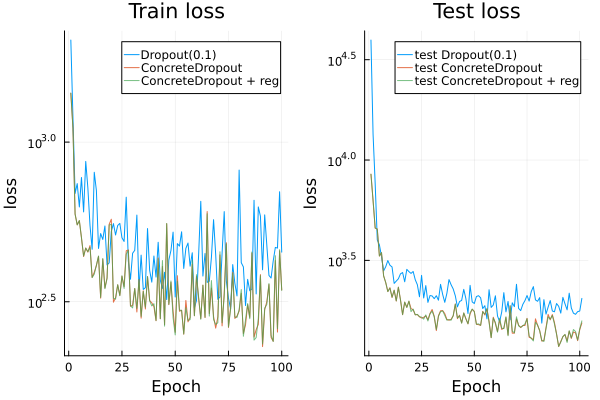

In [16]:
begin
    p_train = plot(loss_train_D, label="Dropout($fix_dropout)", title="Train loss")
    plot!(loss_train_CD, label="ConcreteDropout")
    plot!(loss_train_CD_reg, label="ConcreteDropout + reg", alpha = 0.7)
    xlabel!("Epoch")
    ylabel!("loss", yscale = :log10)
    p_test = plot(loss_val_D, label="test Dropout($fix_dropout)", title="Test loss")
    plot!(loss_val_CD, label="test ConcreteDropout")
    plot!(loss_val_CD_reg, label="test ConcreteDropout + reg", alpha = 0.7)
    xlabel!("Epoch")
    ylabel!("loss", yscale = :log10)
    plot(p_train, p_test)
end

## Monte Carlo predictions

In [17]:
"""
	MC_predict(model, X::AbstractArray{T}; n_samples=1000, kwargs...)
For each X it returns `n_samples` monte carlo simulations where the randomness comes from the (Concrete)Dropout layers.
"""
function MC_predict(model_state, X::AbstractArray, n_samples=1000; dev = gpu_device(), dim_out = model_state.model[end].layers[1].out_dims)
    st = model_state.states
    ps = model_state.parameters
    model = model_state.model

    dim_N = ndims(X)
    mean_arr = similar(X, dim_out, size(X, dim_N))
    std_dev_arr = similar(X, dim_out, size(X, dim_N))

    X = X |> dev
    X_in = similar(X, size(X)[1:end-1]..., n_samples) |> dev


    for (i, x) in enumerate(eachslice(X, dims=dim_N, drop = false))
        X_in .= x
        predictions, st = model(X_in, ps, st)
        θs_MC, logvars = predictions |> cpu_device()

        θ_hat = mean(θs_MC, dims=2) # predictive_mean

        θ2_hat = mean(θs_MC .^ 2, dims=2) #
        var_mean = mean(exp.(logvars), dims=2) # aleatoric uncertainty
        total_var = θ2_hat - θ_hat .^ 2 + var_mean # epistemic + aleatoric uncertainty
        std_dev = sqrt.(total_var)

        mean_arr[:, i] .= θ_hat
        std_dev_arr[:, i] .= std_dev
    end

    return mean_arr, std_dev_arr
end

y_pred, y_std = MC_predict(model_state_out_CD_reg, x_test, dev = dev, dim_out = D)
y_pred_d, y_std_d = MC_predict(model_state_out_D, x_test, dev = dev, dim_out = D)

┌ Warning: `training` is set to `Val{true}()` but is not being used within an autodiff call (gradient, jacobian, etc...). This will be slow. If you are using a `Lux.jl` model, set it to inference (test) mode using `LuxCore.testmode`. Reliance on this behavior is discouraged, and is not guaranteed by Semantic Versioning, and might be removed without a deprecation cycle. It is recommended to fix this issue in your code.
└ @ LuxLib.Utils C:\Users\metivier\.julia\packages\LuxLib\ru5RQ\src\utils.jl:314


(Float32[8.262709 4.5081835 … 9.134797 6.868334], Float32[4.2090874 2.9201372 … 5.13411 3.5231671])

Plot prediction plus standard deviation (aleatoric + epistemic)

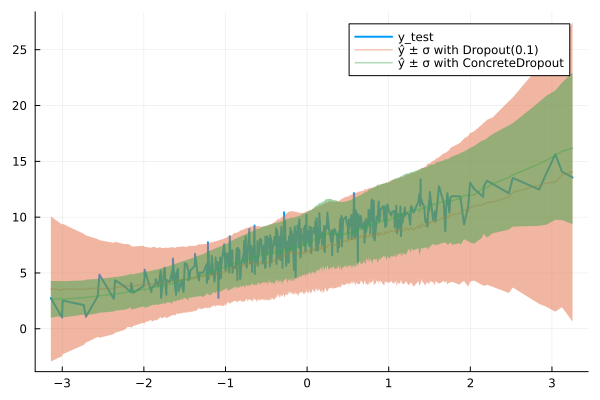

In [18]:
begin
    argsort = sortperm(x_test, dims=2)
    x_sorted = x_test[argsort]'
    y_true_sorted = y_test[argsort]'

    plot(x_sorted, y_true_sorted, label="y_test", lw = 2)
    plot!(x_sorted, y_pred_d[argsort]', ribbon=y_std_d[argsort]', label="ŷ ± σ with Dropout(0.1)", alpha=0.4, lw = 1.5)
    plot!(x_sorted, y_pred[argsort]', ribbon=y_std[argsort]', label="ŷ ± σ with ConcreteDropout", alpha=0.4, lw = 1.5)
end

Print all learned Dropout rates.

In [19]:
println.(p_cd, " -> ConcreteDropout(", get_CD_rates(model_state_out_CD_reg.parameters, p_cd) |> cpu_device() .|> first,")");

KeyPath(:layer_3,) -> ConcreteDropout(0.08212162)
KeyPath(:layer_5,) -> ConcreteDropout(0.08071754)
KeyPath(:layer_6, :layer_1, :layer_2) -> ConcreteDropout(0.05706184)
KeyPath(:layer_6, :layer_2, :layer_2) -> ConcreteDropout(0.08244925)


Without regularization in the loss.

In [20]:
println.(p_cd, " -> ConcreteDropout(", get_CD_rates(model_state_out_CD.parameters, p_cd) |> cpu_device() .|> first,")");

KeyPath(:layer_3,) -> ConcreteDropout(0.08173571)
KeyPath(:layer_5,) -> ConcreteDropout(0.080873184)
KeyPath(:layer_6, :layer_1, :layer_2) -> ConcreteDropout(0.05700031)
KeyPath(:layer_6, :layer_2, :layer_2) -> ConcreteDropout(0.08228464)


---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*